# Estimating RSSNR with Bayesian Linear Regression

In [1]:
! conda install -c conda-forge "pymc>=5"

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - pymc[version='>=5']


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arviz-0.21.0               |     pyhd8ed1ab_0         1.4 MB  conda-forge
    atk-1.0-2.38.0             |       h04ea711_2         348 KB  conda-forge
    binutils_impl_linux-64-2.40|       ha1999f0_7         6.0 MB  conda-forge
    binutils_linux-64-2.40     |       hb3c18ed_9          29 KB  conda-forge
    blas-1.1                   |         openblas           1 KB  conda-forge
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  cond

In [3]:
pip install corner

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import pymc as pm
import corner
import arviz as az

In [3]:
from scipy.optimize import minimize

In [4]:
def combo_scaler(x, range_max=2):
    median_x = np.median(x)
    iqr_x = np.percentile(x,75) - np.percentile(x,25)
    robust_x = ((x-median_x)/iqr_x)

    return (((robust_x - np.nanmin(robust_x)) / (np.nanmax(robust_x) - np.nanmin(robust_x))) * range_max)-1

## Model Exploration on Texas Data

### Import the Texas Data
Bring in the data from the pickle file. At the start, we're limiting this to grounded data.

In [7]:
data = pd.read_pickle('snr_paper_data.pickle')

In [8]:
full_df = data['all_data'].loc[(~np.isnan(data['all_data']['snr'])) & 
                               (~np.isnan(data['all_data']['thickness'])) &
                               (~np.isnan(data['all_data']['surf_temp'])) &
                               (~np.isnan(data['all_data']['base_temp'])) &
                               (~np.isnan(data['all_data']['v'])) &
                               (~np.isnan(data['all_data']['atten']))
                              ]

In [11]:
variable_df = full_df[['snr', 'thickness', 'surf_temp', 
                    'base_temp', 'mask', 'x','y', 'v']]

In [12]:
variable_df['log_v'] = np.log(variable_df['v'])

/srv/conda/envs/notebook/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_141/2886050638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variable_df['log_v'] = np.log(variable_df['v'])


In [13]:
model_df = variable_df[~np.isinf(variable_df['log_v'])]

In [14]:
grounded_df = model_df.loc[model_df['mask']==2]

In [15]:
len(grounded_df)

15823

In [16]:
grounded_df.columns

Index(['snr', 'thickness', 'surf_temp', 'base_temp', 'mask', 'x', 'y', 'v',
       'log_v'],
      dtype='object')

### Norm the Texas Columns of Interest

For now, we'll start with thickness and surface temp (see pairplotting.py for visualization of how much variability is captured by each option)

In [41]:
thickness = grounded_df['thickness']
surf_temp = grounded_df['surf_temp']
snr = grounded_df['snr']

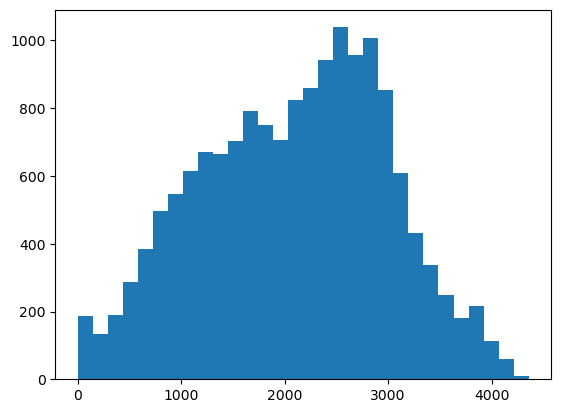

In [21]:
plt.hist(thickness, bins=30);

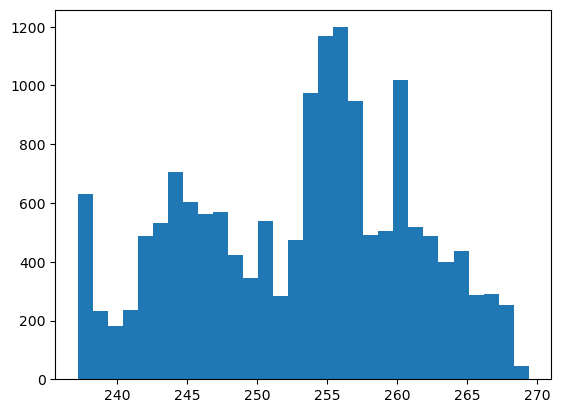

In [22]:
plt.hist(surf_temp, bins=30);

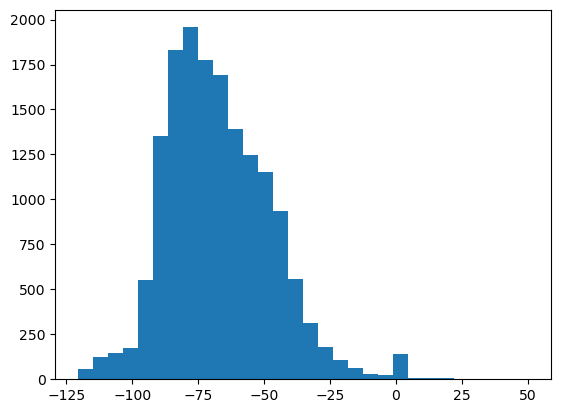

In [42]:
plt.hist(snr, bins=30);

Both of these have heavy tails, so we'll use robust scalar.

In [31]:
def combo_scaler(x, range_max=2):
    median_x = np.median(x)
    iqr_x = np.percentile(x,75) - np.percentile(x,25)
    robust_x = ((x-median_x)/iqr_x)

    return (((robust_x - np.nanmin(robust_x)) / (np.nanmax(robust_x) - np.nanmin(robust_x))) * range_max)-1

In [46]:
norm_thickness = combo_scaler(thickness)

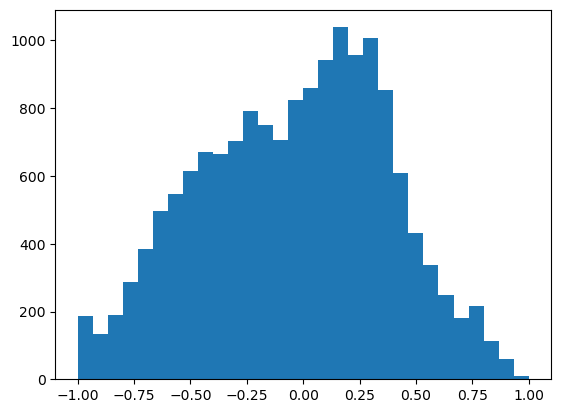

In [47]:
plt.hist(norm_thickness, bins=30);

In [48]:
norm_surf_temp = combo_scaler(surf_temp)

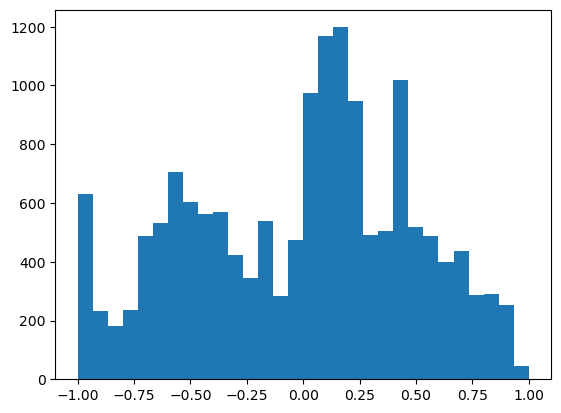

In [49]:
plt.hist(norm_surf_temp, bins=30);

In [50]:
norm_snr = combo_scaler(snr)

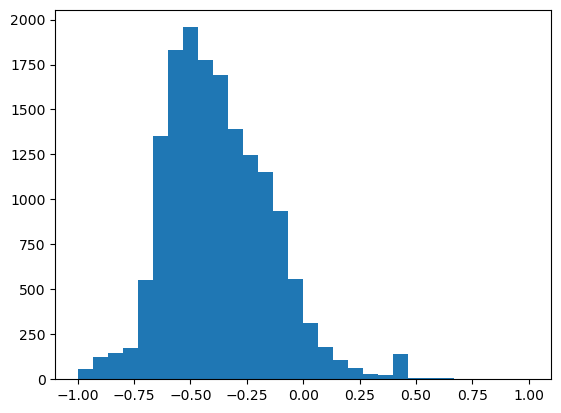

In [51]:
plt.hist(norm_snr, bins=30);

I've combo scaled them to preserve the underlying distribution of the data while keeping the distributions bounded around zero. NOTE! The distribution of snr clearly has a strong outlier, and might benefit from just robust scaling, and having it's long positive tail hang over 1. Can check how this affects outcomes.

### Run a Bayesian Linear Regression on the Texas Data

For now, I'm writing this without measurement uncertainty, but I will fold this in as soon as we have uncertainties. (Note to self: look back at my regression notebook for notes on how to do this properly.)

In [56]:
np.random.seed(42)

def ln_like(theta, thickness_obs, surf_temp_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_temp = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_temp*surf_temp_obs
                           )
    
    # uncertainties = np.sqrt(xerr**2 + yerr**2)
    # ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))

    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [57]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,3) + 0.1 * np.random.randn(3)
likelihood = minimize(nll, initial, 
                      args=(norm_thickness, norm_surf_temp, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_temp_ml = likelihood.x

In [76]:
with pm.Model() as texas_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_thickness + b2*norm_surf_temp

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    texas_trace = pm.sample(10000, cores=3,
                           target_accept=0.8)#,
                           # return_inferencedata=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_surface_temp, nu]


Output()

Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 94 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Now that this has finished running, let's investigate convergence.

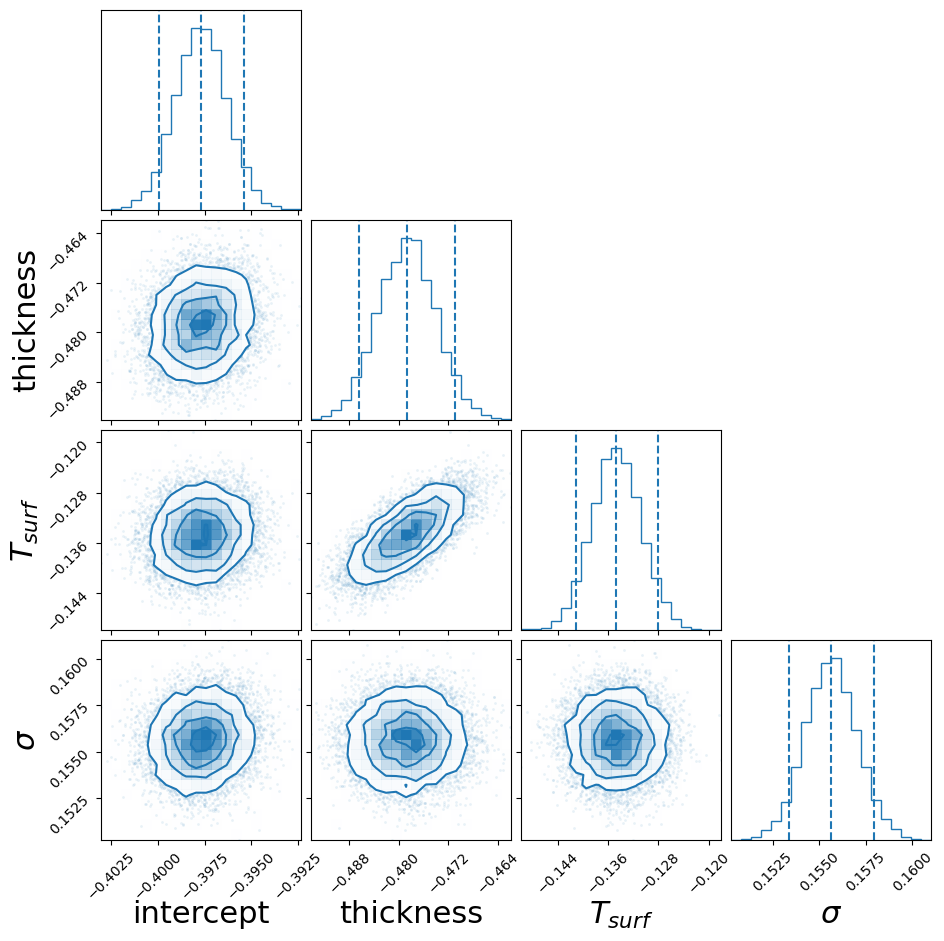

In [66]:
fig = corner.corner(np.vstack((texas_trace.get_values('intercept', chains=0),
                               texas_trace.get_values('beta_thickness', chains=0), 
                               texas_trace.get_values('beta_surface_temp', chains=0),
                               texas_trace.get_values('sigma', chains=0))).T, 
                    labels = ['intercept', 'thickness', 
                              '$T_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

# corner.corner(np.vstack((texas_trace.get_values('intercept', chains=1),
#                          texas_trace.get_values('beta_thickness', chains=1), 
#                          texas_trace.get_values('beta_surface_temp', chains=1),
#                          texas_trace.get_values('sigma', chains=1))).T,
#               color='#ff7f0e', alpha=0.25,
#               quantiles=[0.05, 0.5, 0.95])

# corner.corner(np.vstack((texas_trace.get_values('intercept', chains=2),
#                          texas_trace.get_values('beta_thickness', chains=2), 
#                          texas_trace.get_values('beta_surface_temp', chains=2),
#                          texas_trace.get_values('sigma', chains=2))).T,
#               color='#2ca02c', alpha=0.25,
#               quantiles=[0.05, 0.5, 0.95])

Let's look more closely at these coefficients:

In [77]:
az.summary(texas_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 'beta_thickness', 
                                                          'beta_surface_temp', 'sigma'], :]

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.398,0.001,-0.399,-0.396,0.0,0.0,25892.364,20749.347,1.0
beta_thickness,-0.479,0.005,-0.484,-0.474,0.0,0.0,24152.443,21037.689,1.0
beta_surface_temp,-0.135,0.004,-0.139,-0.131,0.0,0.0,23572.298,21381.778,1.0
sigma,0.156,0.001,0.154,0.157,0.0,0.0,24063.142,22340.153,1.0


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_thickness'}>,
        <Axes: title={'center': 'beta_thickness'}>],
       [<Axes: title={'center': 'beta_surface_temp'}>,
        <Axes: title={'center': 'beta_surface_temp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

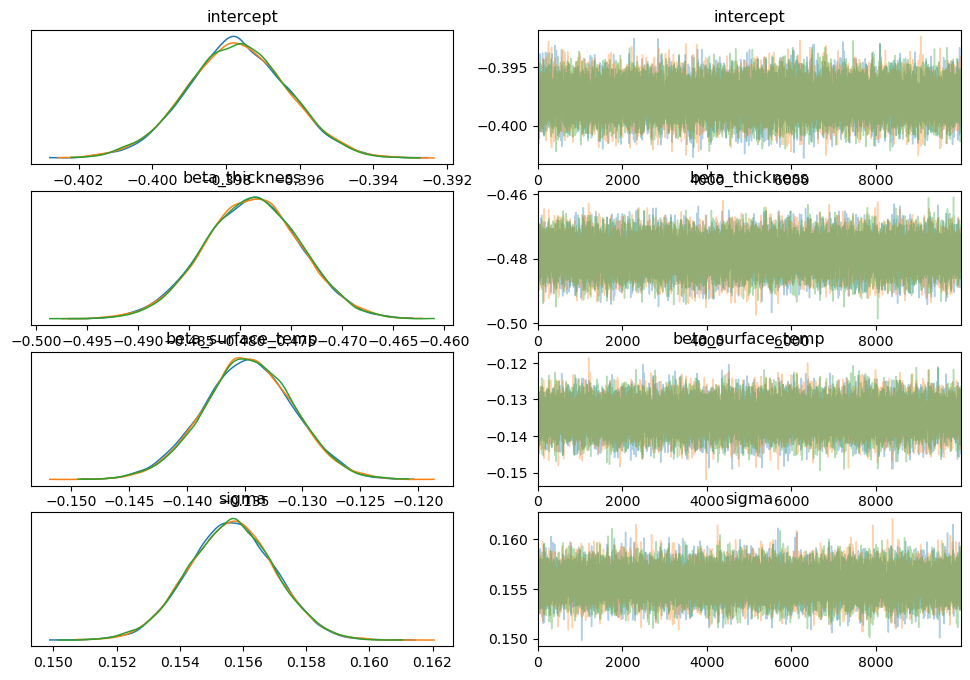

In [78]:
az.plot_trace(texas_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_temp', 'sigma'], 
              combined=False, compact=False)

## Model Exploration on the CRESIS Data

### Import CRESIS

In [5]:
data = xr.open_dataset('snr_data_cresis_ais_with_inputs.nc')

In [6]:
data

<xarray.Dataset> Size: 131MB
Dimensions:          (index: 552886)
Coordinates:
  * index            (index) int64 4MB 0 10 20 30 ... 5528830 5528840 5528850
Data variables:
    x                (index) float64 4MB ...
    y                (index) float64 4MB ...
    snr              (index) float64 4MB ...
    source_csv_file  (index) <U24 53MB ...
    source_mat_file  (index) <U24 53MB ...
    thickness        (index) float32 2MB ...
    thickness_err    (index) float32 2MB ...
    bm_mask          (index) int8 553kB ...
    surface          (index) float32 2MB ...

In [7]:
cresis_df = data.to_dataframe()

In [8]:
cresis_df

,x,y,snr,source_csv_file,source_mat_file,thickness,thickness_err,bm_mask,surface
index,,,,,,,,,
0,2.522879e+06,-798696.355175,-2.398550,Data_20191029_01_003.csv,Data_20191029_01_003.mat,0.000000,NaN,0,0.000000
10,2.522729e+06,-798666.842782,0.000000,Data_20191029_01_003.csv,Data_20191029_01_003.mat,0.000000,NaN,0,0.000000
20,2.522579e+06,-798637.250474,0.000000,Data_20191029_01_003.csv,Data_20191029_01_003.mat,0.000000,NaN,0,0.000000
30,2.522430e+06,-798607.744549,0.000000,Data_20191029_01_003.csv,Data_20191029_01_003.mat,0.000000,NaN,0,0.000000
40,2.522280e+06,-798578.447257,0.000000,Data_20191029_01_003.csv,Data_20191029_01_003.mat,0.000000,NaN,0,0.000000
...,...,...,...,...,...,...,...,...,...
5528810,2.994412e+05,36016.275593,-2.896412,Data_20230109_01_022.csv,Data_20230109_01_022.mat,3461.643799,335.0,2,3074.816162
5528820,2.992082e+05,35884.991361,-4.415756,Data_20230109_01_022.csv,Data_20230109_01_022.mat,3462.634277,339.0,2,3073.900635
5528830,2.989746e+05,35754.381782,-2.868750,Data_20230109_01_022.csv,Data_20230109_01_022.mat,3462.634277,339.0,2,3073.900635


In [9]:
var_list = ['snr', 'thickness', 'thickness_err', 
            'bm_mask', 'surface'
           ]

In [10]:
full_df = cresis_df.loc[~np.isnan(cresis_df['snr']) &
                        ~np.isnan(cresis_df['thickness']) &
                        ~np.isnan(cresis_df['thickness_err']) &
                        ~np.isnan(cresis_df['bm_mask']) &
                        ~np.isnan(cresis_df['surface'])][var_list]

In [11]:
grounded_df = full_df.loc[full_df['bm_mask']==2]

In [12]:
floating_df = full_df.loc[full_df['bm_mask']==3]

In [13]:
len(grounded_df)

444923

In [14]:
len(floating_df)

73381

### Norm the CRESIS variable columns for Grounded Ice

We'll do two different normalizations for grounded and floating ice, because we expect them to be from different underlying distributions.

In [15]:
grounded_thickness = grounded_df['thickness']
grounded_elevation = grounded_df['surface']
grounded_snr = grounded_df['snr']

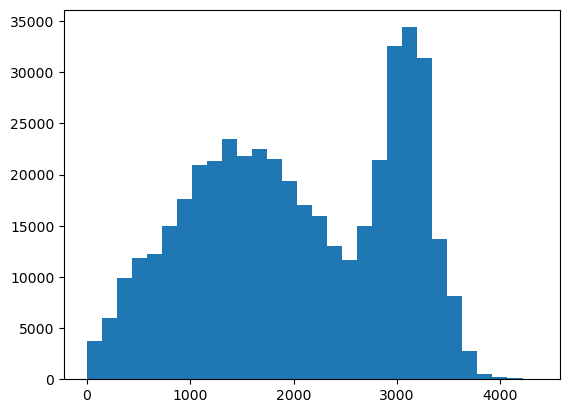

In [16]:
plt.hist(grounded_thickness, bins=30);

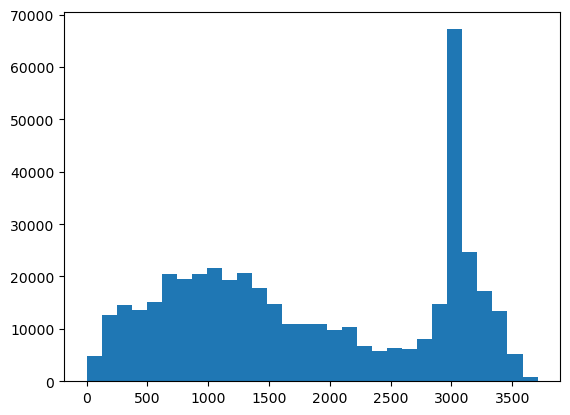

In [17]:
plt.hist(grounded_elevation, bins=30);

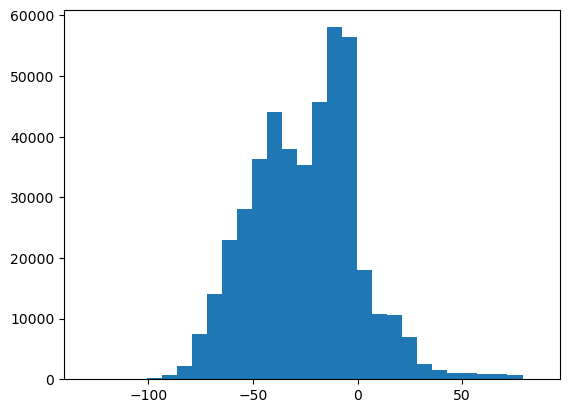

In [18]:
plt.hist(grounded_snr, bins=30);

In [19]:
norm_grounded_thickness = combo_scaler(grounded_thickness)

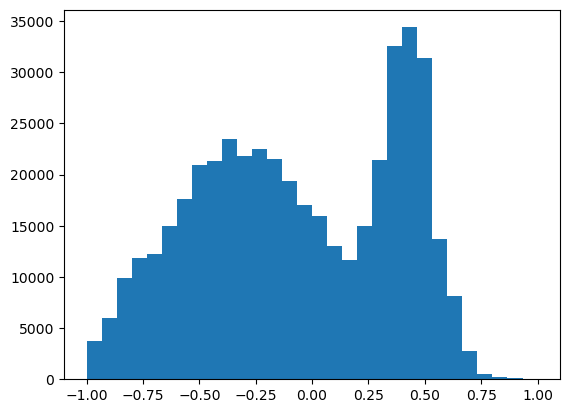

In [20]:
plt.hist(norm_grounded_thickness, bins=30);

In [21]:
norm_grounded_elevation = combo_scaler(grounded_elevation)

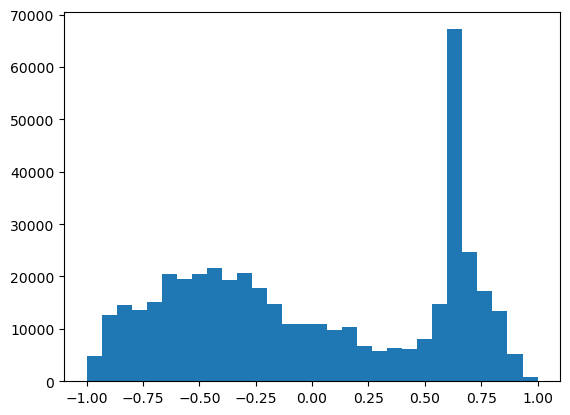

In [22]:
plt.hist(norm_grounded_elevation, bins=30);

In [23]:
norm_grounded_snr = combo_scaler(grounded_snr)

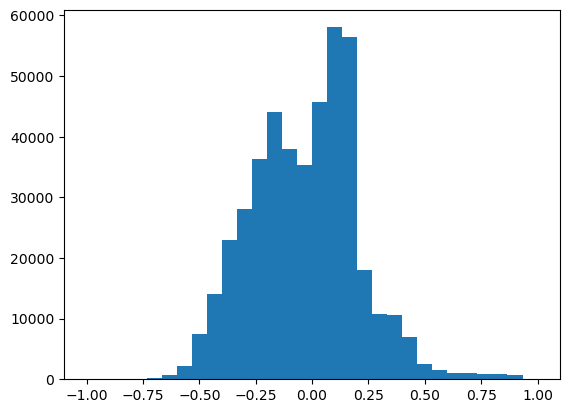

In [24]:
plt.hist(norm_grounded_snr, bins=30);

### Bayesian Linear Regression on Cresis Data

I'm assuming here that the data is student t distributed (see Texas section for more details). To fold uncertainties in, we need to propagate through the scaling for their mean value. I'll add that in after some initial model exploration.

In [25]:
np.random.seed(42)

def ln_like(theta, thickness_obs, surf_elevation_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_elevation = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_elevation*surf_elevation_obs
                           )
    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [26]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,3) + 0.1 * np.random.randn(3)
likelihood = minimize(nll, initial, 
                      args=(norm_grounded_thickness, norm_grounded_elevation, 
                            norm_grounded_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_elevation_ml = likelihood.x

In [27]:
with pm.Model() as cresis_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_elevation", beta_surf_elevation_ml, sigma=10)
    

    # Define linear model
    y_est = b0 + b1*norm_grounded_thickness + b2*norm_grounded_elevation

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_grounded_snr
    )
    
    cresis2_trace = pm.sample(10000, cores=3,
                              target_accept=0.8, 
                              return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_surface_elevation, nu]


Output()

Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 1527 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


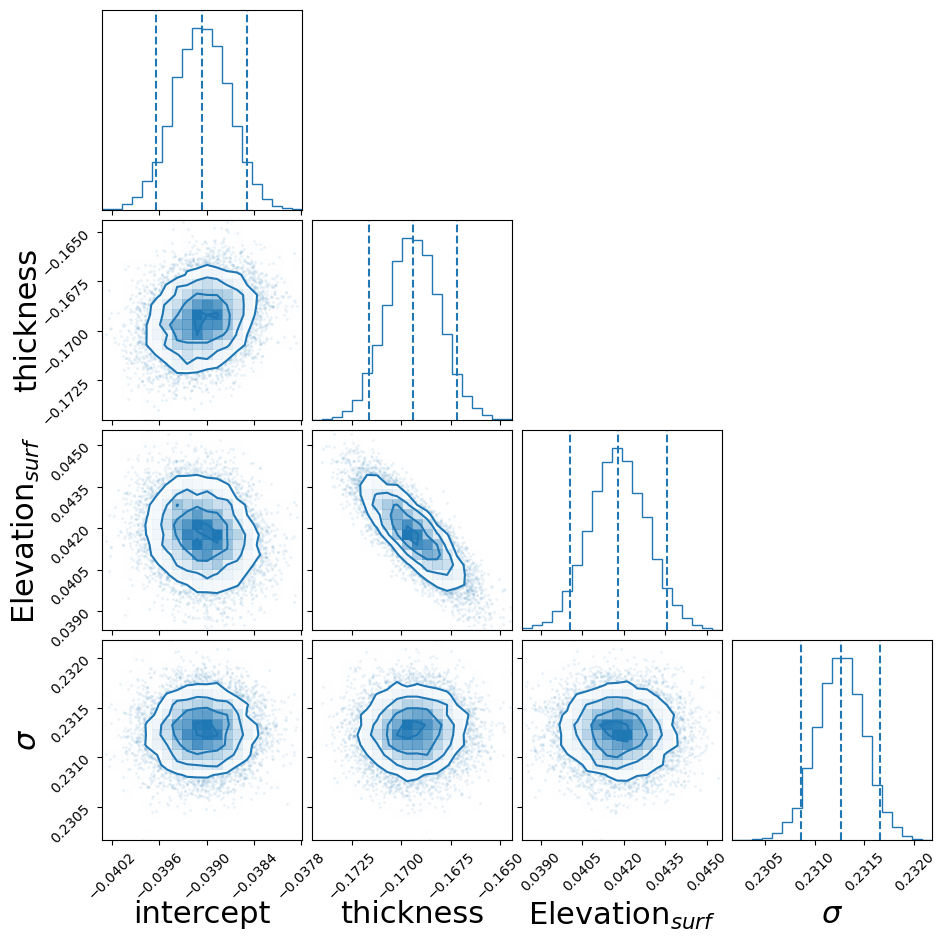

In [32]:
fig = corner.corner(np.vstack((cresis2_trace.posterior['intercept'][0],
                               cresis2_trace.posterior['beta_thickness'][0], 
                               cresis2_trace.posterior['beta_surface_elevation'][0],
                               cresis2_trace.posterior['sigma'][0])).T, 
                    labels = ['intercept', 'thickness', 
                              'Elevation$_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

In [33]:
az.summary(cresis2_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 'beta_thickness', 
                                                          'beta_surface_elevation', 
                                                           'sigma'], :]

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.039,0.000,-0.039,-0.039,0.0,0.0,28027.590,21430.495,1.0
beta_thickness,-0.169,0.001,-0.171,-0.168,0.0,0.0,19663.418,20108.518,1.0
beta_surface_elevation,0.042,0.001,0.041,0.043,0.0,0.0,20218.625,20322.491,1.0
sigma,0.231,0.000,0.231,0.232,0.0,0.0,28409.183,20633.055,1.0


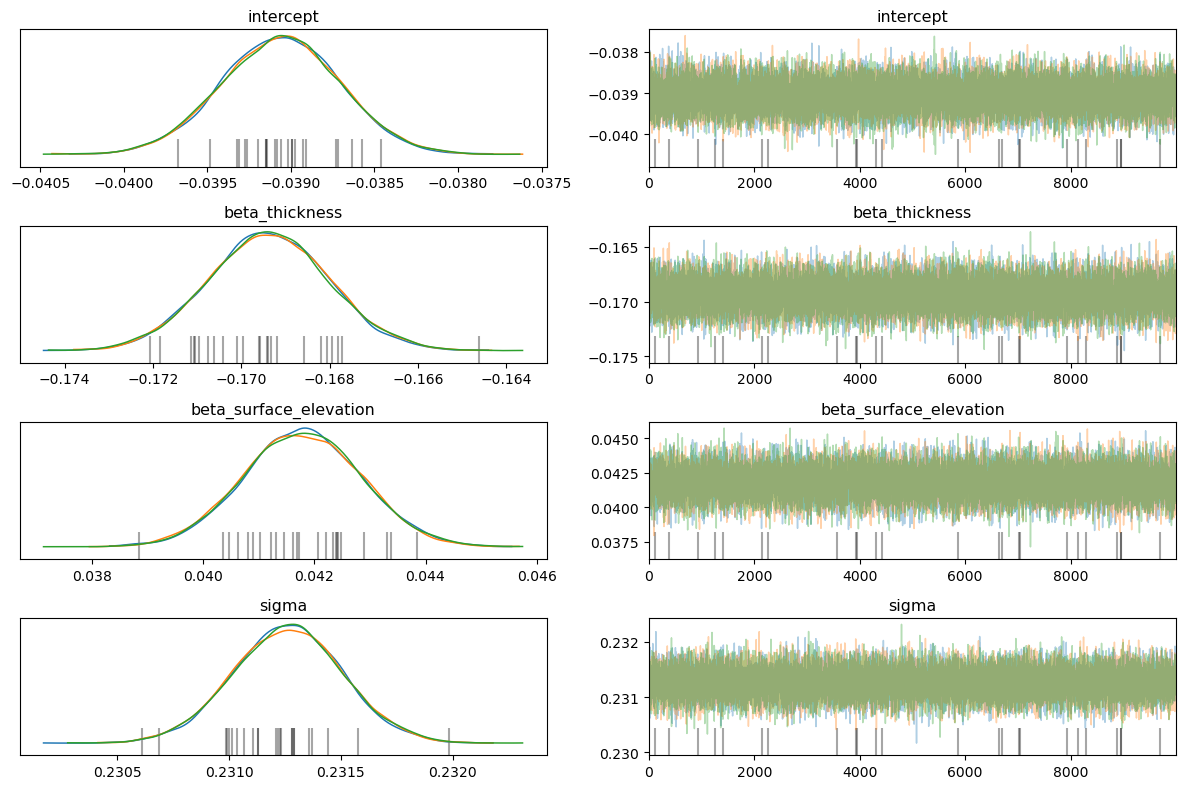

In [35]:
az.plot_trace(cresis2_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_elevation', 'sigma'], 
              combined=False, compact=False)
plt.tight_layout()